In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install requests
!pip install lxml

<b>1) Use python to clean the data, get descriptive statistics and default correlations among these variables. (5 marks)</b>

In [2]:
import pandas as pd

# Step 1: Extract the table from the website
url = "https://www.worldometers.info/population/countries-in-africa-by-population/"
tables = pd.read_html(url)
df = tables[0]  # Extract the first table

# Step 2: Rename columns for easier reference
df.columns = ['Rank', 'Country', 'Population', 'Yearly_Change', 'Net_Change',
              'Density (P/Km²)', 'Land_Area (Km²)', 'Migrants', 'Fertility_Rate',
              'Median_Age', 'Urban_Population', 'World_Share']

# Step 3: Data Cleaning
df = df.replace({'N.A.': None, ',': '', '%': ''}, regex=True)  # Remove commas and percentages
numeric_cols = ['Rank', 'Population', 'Yearly_Change', 'Net_Change', 'Density (P/Km²)',
                'Land_Area (Km²)', 'Migrants', 'Fertility_Rate', 'Median_Age',
                'Urban_Population', 'World_Share']

# Convert numeric columns properly
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float, setting errors to NaN

# Step 4: Get descriptive statistics
desc_stats = df.describe()

# Step 5: Compute default correlations (exclude non-numeric columns)
correlations = df[numeric_cols].corr()

# Display results
print("Descriptive Statistics:\n", desc_stats)
print("\nCorrelation Matrix:\n", correlations)


Descriptive Statistics:
             Rank    Population  Yearly_Change    Net_Change  Density (P/Km²)  \
count  58.000000  5.800000e+01      58.000000  5.800000e+01        58.000000   
mean   29.500000  2.612312e+07       2.142069  5.925918e+05       131.689655   
std    16.886879  3.987530e+07       1.014162  9.126682e+05       175.534093   
min     1.000000  5.237000e+03      -0.980000 -2.419000e+03         2.000000   
25%    15.250000  2.525592e+06       1.762500  4.955050e+04        29.000000   
50%    29.500000  1.415218e+07       2.245000  3.257065e+05        69.500000   
75%    43.750000  3.195727e+07       2.642500  7.406598e+05       131.500000   
max    58.000000  2.326795e+08       5.070000  4.796533e+06       871.000000   

       Land_Area (Km²)       Migrants  Fertility_Rate  Median_Age  \
count     5.800000e+01      58.000000       58.000000   58.000000   
mean      5.111807e+05  -11108.120690        3.713793   21.413793   
std       5.848486e+05   84518.921666        1.

<b>Create a simple Linear Regression model between the two features and determine the r-squared and mean square error values with graphical representation</b>

R-squared (R²): -1.5770
Mean Squared Error (MSE): 488.06


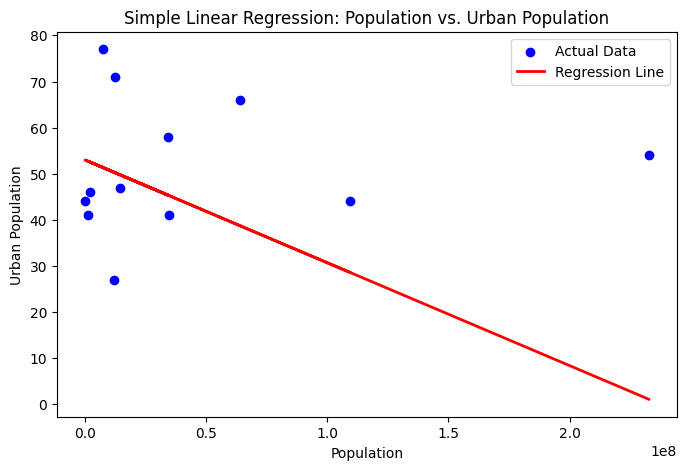

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Extract the table from the website
url = "https://www.worldometers.info/population/countries-in-africa-by-population/"
tables = pd.read_html(url)
df = tables[0]  # Extract the first table

# Step 2: Rename columns for easier reference
df.columns = ['Rank', 'Country', 'Population', 'Yearly_Change', 'Net_Change',
              'Density (P/Km²)', 'Land_Area (Km²)', 'Migrants', 'Fertility_Rate',
              'Median_Age', 'Urban_Population', 'World_Share']

# Step 3: Data Cleaning
df = df.replace({'N.A.': None, ',': '', '%': ''}, regex=True)  # Remove commas and percentages
numeric_cols = ['Population', 'Urban_Population']

# Convert numeric columns properly
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df = df.dropna(subset=numeric_cols)

# Step 4: Define X (Population) and Y (Urban Population)
X = df[['Population']]  # Independent variable
y = df['Urban_Population']  # Dependent variable

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test)

# Step 7: Compute R-squared and Mean Squared Error (MSE)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print performance metrics
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Step 8: Visualization
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel("Population")
plt.ylabel("Urban Population")
plt.title("Simple Linear Regression: Population vs. Urban Population")
plt.legend()
plt.show()



<b>3) Create a Multiple Linear Regression model between the other  features  where Net Change is dependent variable. Thus,  determine the r-squared and mean square error values with graphical representation. (5 marks)</b>

R-squared (R²): 0.9280
Mean Squared Error (MSE): 156607670349.33


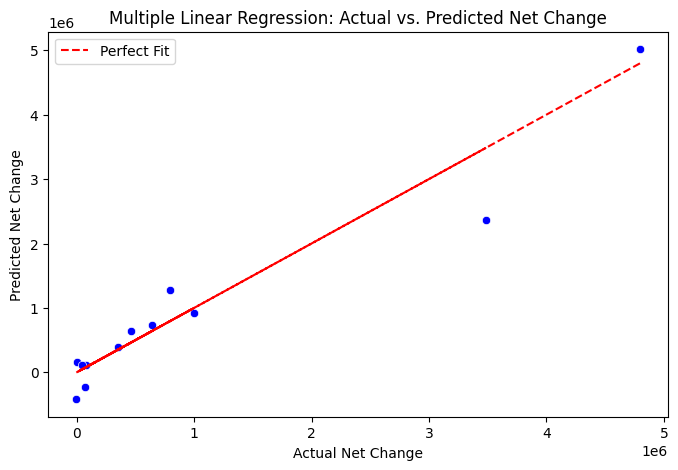

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Extract the table from the website
url = "https://www.worldometers.info/population/countries-in-africa-by-population/"
tables = pd.read_html(url)
df = tables[0]  # Extract the first table

# Step 2: Rename columns for easier reference
df.columns = ['Rank', 'Country', 'Population', 'Yearly_Change', 'Net_Change',
              'Density (P/Km²)', 'Land_Area (Km²)', 'Migrants', 'Fertility_Rate',
              'Median_Age', 'Urban_Population', 'World_Share']

# Step 3: Data Cleaning
df = df.replace({'N.A.': None, ',': '', '%': ''}, regex=True)  # Remove commas and percentages

# Define relevant numeric columns
numeric_cols = ['Population', 'Yearly_Change', 'Net_Change', 'Density (P/Km²)',
                'Land_Area (Km²)', 'Migrants', 'Fertility_Rate', 'Median_Age',
                'Urban_Population', 'World_Share']

# Convert numeric columns properly
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df = df.dropna(subset=numeric_cols)

# Step 4: Define X (Independent Variables) and y (Dependent Variable)
X = df.drop(columns=['Net_Change', 'Rank', 'Country'])  # Drop non-numeric and target column
y = df['Net_Change']

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train the Multiple Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test)

# Step 7: Compute R-squared and Mean Squared Error (MSE)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print performance metrics
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Step 8: Visualization - Actual vs. Predicted Net Change
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, color='blue')
plt.plot(y_test, y_test, color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Actual Net Change")
plt.ylabel("Predicted Net Change")
plt.title("Multiple Linear Regression: Actual vs. Predicted Net Change")
plt.legend()
plt.show()


<b> 4) Create a polynomial  Regression model between the two features media age and fertility rate. Hence determine the r-squared and mean square error values with graphical representation. (5 marks)</b>

R-squared (R²): 0.8394
Mean Squared Error (MSE): 0.28


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


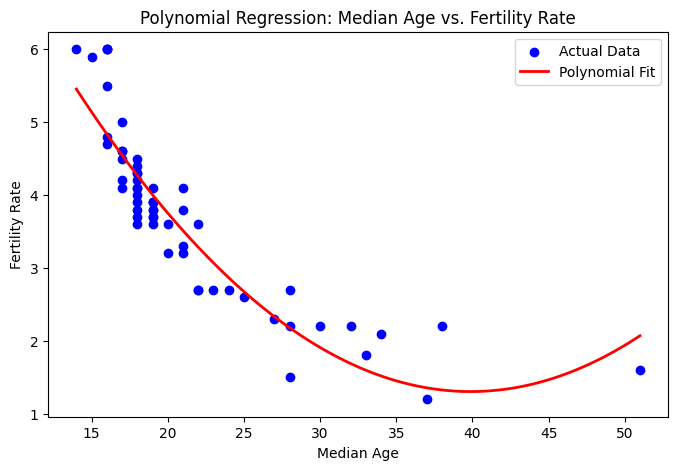

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Extract the table from the website
url = "https://www.worldometers.info/population/countries-in-africa-by-population/"
tables = pd.read_html(url)
df = tables[0]  # Extract the first table

# Step 2: Rename columns for easier reference
df.columns = ['Rank', 'Country', 'Population', 'Yearly_Change', 'Net_Change',
              'Density (P/Km²)', 'Land_Area (Km²)', 'Migrants', 'Fertility_Rate',
              'Median_Age', 'Urban_Population', 'World_Share']

# Step 3: Data Cleaning
df = df.replace({'N.A.': None, ',': '', '%': ''}, regex=True)  # Remove commas and percentages

# Convert relevant numeric columns
numeric_cols = ['Median_Age', 'Fertility_Rate']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df = df.dropna(subset=numeric_cols)

# Step 4: Define X (Median Age) and y (Fertility Rate)
X = df[['Median_Age']]
y = df['Fertility_Rate']

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Transform X using Polynomial Features (Degree = 2)
poly = PolynomialFeatures(degree=2)  # Quadratic polynomial regression
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Step 6: Train the Polynomial Regression Model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Step 7: Make predictions
y_pred = model.predict(X_test_poly)

# Step 8: Compute R-squared and Mean Squared Error (MSE)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print performance metrics
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Step 9: Visualization - Polynomial Regression Curve
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label="Actual Data")  # Scatter plot of actual data

# Generate smooth curve for visualization
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)  # Generate X values for plotting
X_range_poly = poly.transform(X_range)
y_range_pred = model.predict(X_range_poly)

plt.plot(X_range, y_range_pred, color='red', linewidth=2, label="Polynomial Fit")
plt.xlabel("Median Age")
plt.ylabel("Fertility Rate")
plt.title("Polynomial Regression: Median Age vs. Fertility Rate")
plt.legend()
plt.show()
